## Citations
https://www.alphaquery.com/stock/NFLX/profile-key-metrics

# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy import stats

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from helper_functions import stationary_test

import warnings
warnings.filterwarnings('ignore')

In [ ]:
prices = pd.read_csv('/content/drive/MyDrive/stock_model/NFLX_fuller.csv',
                        parse_dates=['Date']).set_index('Date')
prices = prices['2015':]

fiscal = pd.read_csv('/content/drive/MyDrive/stock_model/Financial_stats_NFLX.csv',
                 parse_dates = ['Announcement Date'],
                     index_col = ['Announcement Date'])

fiscal = fiscal['2015':]

sentiment = pd.read_csv('/content/drive/MyDrive/stock_model/nflx_full_sentiment.csv',
                        parse_dates = ['date'],
                        index_col = ['date'])
spx = pd.read_csv('/content/drive/MyDrive/stock_model/SPX.csv',
                  parse_dates=['Date']).set_index('Date')['Close/Last']
spx = spx['2015':]

In [ ]:
dfs = [prices, fiscal, sentiment, spx]
for df in dfs:
    display(df.head())
    display(df.tail())

,Close,Volume,Open,High,Low
Date,,,,,
2023-06-16,431.96,8753740,446.15,447.51,430.90
2023-06-15,445.27,7099915,444.10,448.65,439.50
2023-06-14,440.86,8413089,434.99,447.33,433.50
2023-06-13,435.73,7820535,430.01,437.27,428.40
2023-06-12,423.97,5967712,418.83,424.70,416.57


,Close,Volume,Open,High,Low
Date,,,,,
2015-01-08,47.78,9622448,47.12,47.84,46.48
2015-01-07,46.74,9832490,47.35,47.42,46.27
2015-01-06,46.50,15984680,47.35,47.64,45.66
2015-01-05,47.31,18107696,49.26,49.26,47.15
2015-01-02,49.85,13322173,49.15,50.33,48.73


,Fiscal Quarter End,Estimated EPS,Actual EPS
Announcement Date,,,
2023-04-18,2023-03-31,2.83,2.88
2023-01-19,2022-12-31,0.47,0.12
2022-10-18,2022-09-30,2.11,3.10
2022-07-19,2022-06-30,2.90,3.20
2022-04-19,2022-03-31,2.92,3.53


,Fiscal Quarter End,Estimated EPS,Actual EPS
Announcement Date,,,
2016-01-19,2015-12-31,0.02,0.07
2015-10-14,2015-09-30,0.07,0.07
2015-07-15,2015-06-30,0.01,0.01
2015-04-15,2015-03-31,0.10,0.11
2015-01-20,2014-12-31,0.06,0.10


,Unnamed: 0,count,normalized
date,,,
2023-06-13,0,4,0.4610
2023-06-12,1,1,0.5570
2023-06-11,2,3,0.7410
2023-06-10,3,1,0.9060
2023-06-09,4,22,0.5721


,Unnamed: 0,count,normalized
date,,,
2018-07-12,915,1,0.973
2018-06-14,916,1,0.995
2018-04-17,917,1,0.995
2018-03-16,918,1,0.991
2018-02-02,919,1,0.996


Date
2023-06-16    4409.59
2023-06-15    4425.84
2023-06-14    4372.59
2023-06-13    4369.01
2023-06-12    4338.93
Name: Close/Last, dtype: float64

Date
2015-01-07    2025.90
2015-01-06    2002.61
2015-01-05    2020.58
2015-01-02    2058.20
2015-01-01    2058.90
Name: Close/Last, dtype: float64

# Exploratory Data Analysis

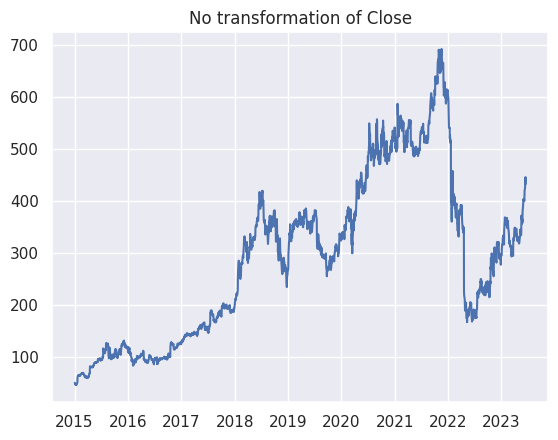

ADF Statistic: -0.787125
p value: 0.822875
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.568
The null hypothesis that the series is NOT stationary cannot be rejected.



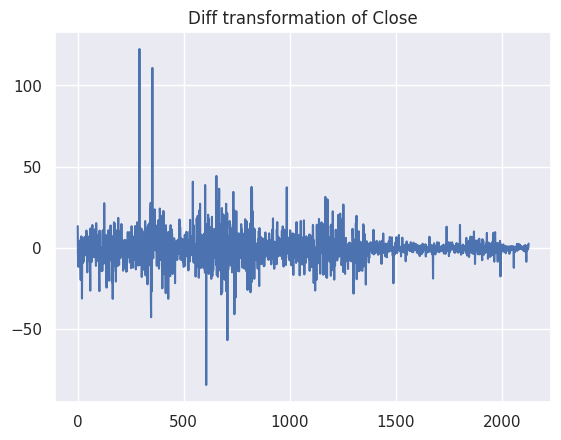

ADF Statistic: -10.126370
p value: 0.000000
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.568
Null hypothesis that the series is not stationary can be REJECTED.


In [ ]:
# testing the stationarity of the prices['Close']
import matplotlib.pyplot as plt
stationary_test(prices,'Close')


* So `.diff()` is sufficient to transform prices['Close']. However, I want to represent the rise/fall in relation to the current price.

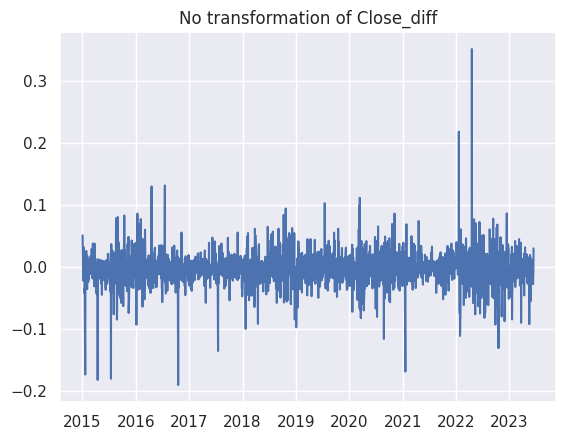

ADF Statistic: -31.360083
p value: 0.000000
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.567
Null hypothesis that the series is not stationary can be REJECTED.


In [ ]:
prices['Close_diff'] = prices['Close'].diff()/prices['Close']
stationary_test(prices, 'Close_diff')

In [ ]:
prices = prices.drop(columns='Close')
prices['Close'] = prices['Close_diff']
prices = prices.drop(columns='Close_diff')

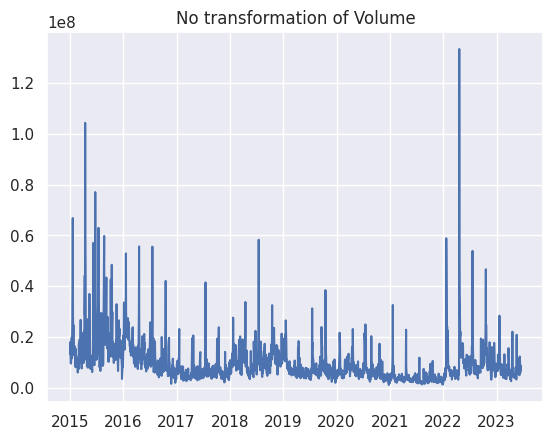

ADF Statistic: -4.344442
p value: 0.000372
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.568
Null hypothesis that the series is not stationary can be REJECTED.


In [ ]:
## running the stationarity test on volume and sentiment
stationary_test(prices, 'Volume')

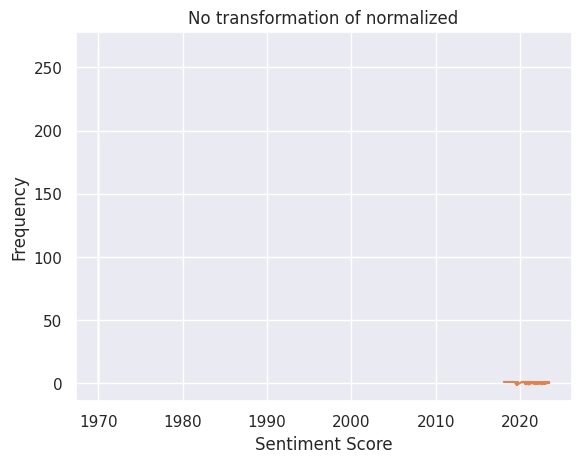

ADF Statistic: -6.262991
p value: 0.000000
Critical value: 
t1%: -3.438
t5%: -2.865
t10%: -2.568
Null hypothesis that the series is not stationary can be REJECTED.


In [ ]:
# remove unnecessary index column from sentiment
sentiment = sentiment.drop(columns = ['Unnamed: 0', 'count'])
# view the data
plt.hist(sentiment)
plt.ylabel('Frequency')
plt.xlabel('Sentiment Score')
# running stationary test on sentiment
stationary_test(sentiment, 'normalized')

## Fiscal EDA

- Prove/disprove the Hypothesis that the Actual EPS and Esimate EPS are correlating strongly.

- Check EPS for stationarity and fix it accordingly.

- Merge this value into the main 'prices index' and backfill populate the missing values (i.e there should be an EPS for every record, not just the annoucement dates'

- Use financial data to fill any missing values that cannot be back filled i.e. the time period between April - June

In [ ]:
fiscal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 2023-04-18 to 2015-01-20
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fiscal Quarter End  34 non-null     object 
 1   Estimated EPS       34 non-null     float64
 2   Actual EPS          34 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


In [ ]:
fiscal = pd.read_csv('/content/drive/MyDrive/stock_model/Financial_stats_NFLX.csv',
                 parse_dates = ['Announcement Date'],
                     index_col = ['Announcement Date'])

The Null test for correlation between these 2 columns is not rejected. They are correlated strongly.


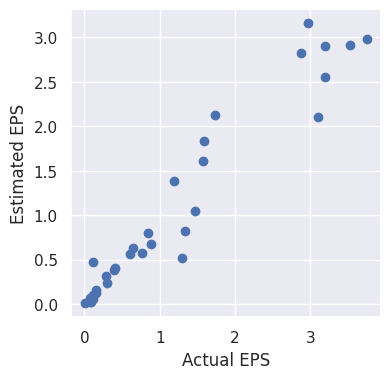

In [ ]:
# confirming the correlation between Actual EPS and Estimated EPS
plt.figure(figsize=(4,4))
plt.scatter(fiscal['Actual EPS'], fiscal['Estimated EPS'])
plt.xlabel('Actual EPS')
plt.ylabel('Estimated EPS')
from scipy import stats
res, p = stats.pearsonr(fiscal['Estimated EPS'], fiscal['Actual EPS'])
print ('The Null test for correlation between these 2 columns is',
       'REJECTED' if p>0.05 else 'not rejected. They are correlated',
       'strongly.' if res>0.9 else '.')

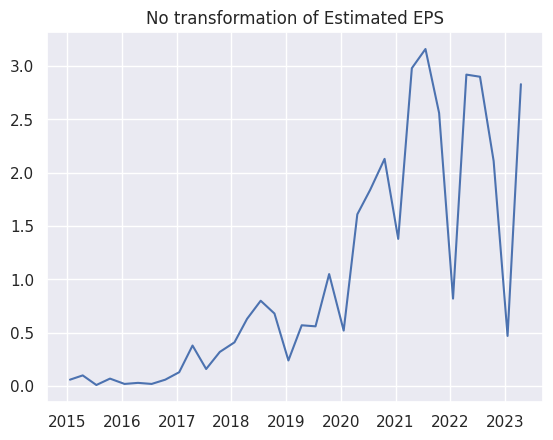

ADF Statistic: -2.038468
p value: 0.269965
Critical value: 
t1%: -3.738
t5%: -2.992
t10%: -2.636
The null hypothesis that the series is NOT stationary cannot be rejected.



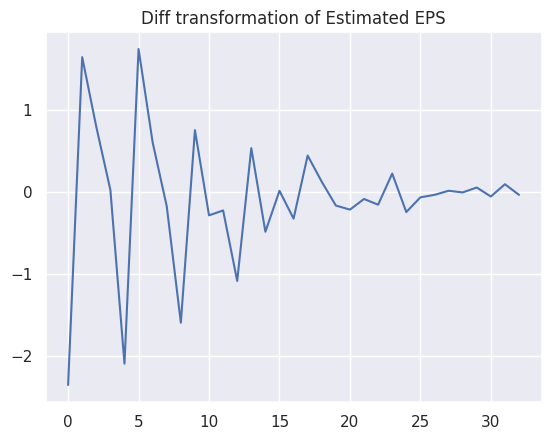

ADF Statistic: -1.852927
p value: 0.354519
Critical value: 
t1%: -3.679
t5%: -2.968
t10%: -2.623
The null hypothesis that the series is NOT stationary cannot be rejected.



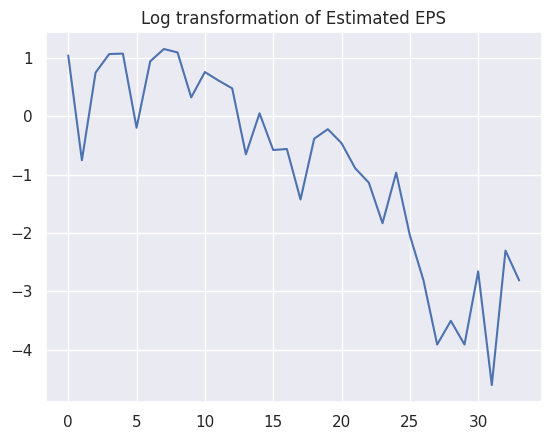

ADF Statistic: 1.077288
p value: 0.995018
Critical value: 
t1%: -3.753
t5%: -2.998
t10%: -2.639
The null hypothesis that the series is NOT stationary cannot be rejected.



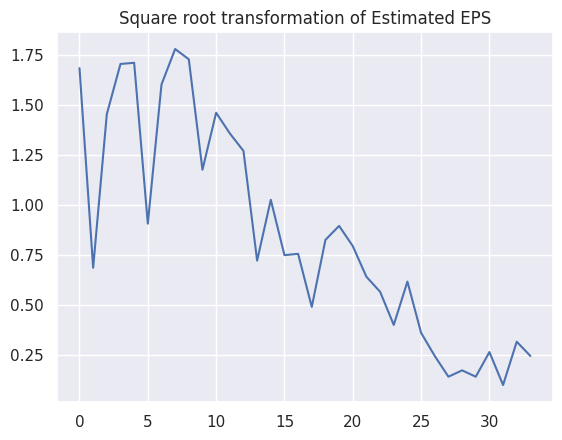

ADF Statistic: -1.072402
p value: 0.725951
Critical value: 
t1%: -3.738
t5%: -2.992
t10%: -2.636
The null hypothesis that the series is NOT stationary cannot be rejected.



In [ ]:
# checking Estimated EPS for stationarity
# will assume that this suffices for Actual EPS as well since we can see they are correlating strongly
stationary_test(fiscal, 'Estimated EPS')

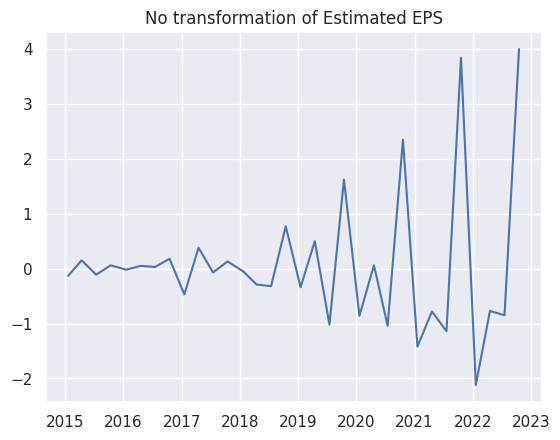

ADF Statistic: -23.519120
p value: 0.000000
Critical value: 
t1%: -3.679
t5%: -2.968
t10%: -2.623
Null hypothesis that the series is not stationary can be REJECTED.


In [ ]:
## trying the diff of the diff
fiscal['Estimated EPS'] = fiscal['Estimated EPS'].diff().diff()
stationary_test(fiscal, 'Estimated EPS')

## SPX EDA



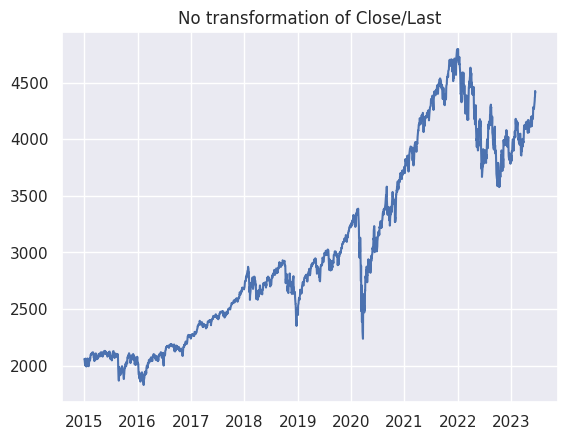

ADF Statistic: -1.173095
p value: 0.685061
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.567
The null hypothesis that the series is NOT stationary cannot be rejected.



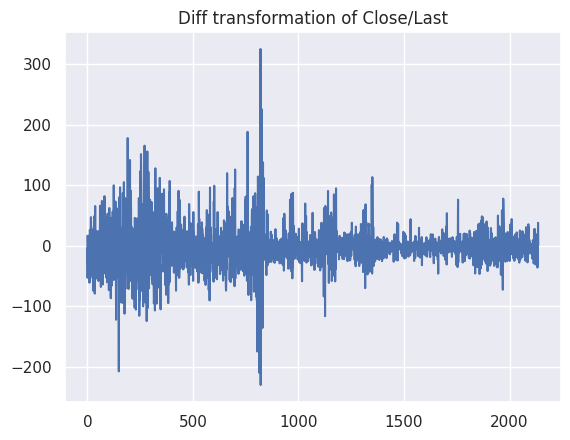

ADF Statistic: -14.441056
p value: 0.000000
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.567
Null hypothesis that the series is not stationary can be REJECTED.


In [ ]:
spx = spx.to_frame()
stationary_test(spx, 'Close/Last')

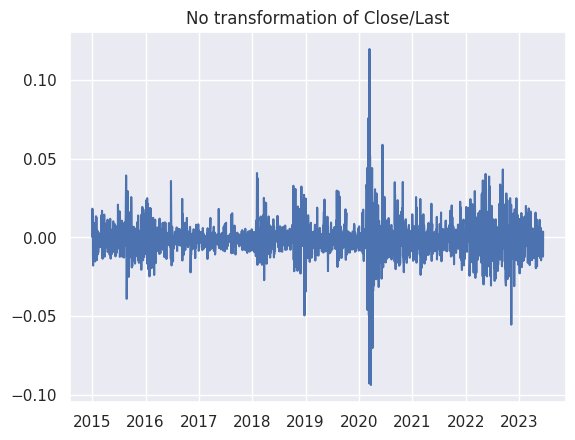

ADF Statistic: -14.434278
p value: 0.000000
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.567
Null hypothesis that the series is not stationary can be REJECTED.


In [ ]:
# to be consistent with the NFLX Close transformation, we will also transform this as a delta of its previous price

spx = spx.diff()/spx
stationary_test(spx, 'Close/Last')



## Merging all the features into the main prices list

* Now that I've sorted out the issues of stationary, I can now start merging the features, and doing other statistical tests.

** IMPORTANT** : As this is a **predictor** model, all the features will be time-shifted by 1 Business Day lag. the present-day information can only affect next-day values of y. (The effect of weekends and holidays etc will be considered during further refinement of the model).

In [ ]:
# merge into the fiscal df first main prices index so that we can populate all the records

fiscal = fiscal.merge(prices, how='outer', left_index=True, right_index=True)
fiscal = fiscal.fillna(method='bfill')
fiscal = fiscal.fillna(method='ffill')
fiscal['Fiscal Quarter End'] = fiscal['Fiscal Quarter End'].fillna('2014-09-30')
fiscal.loc['2023-04-19':,'Fiscal Quarter End'] = '2023-06-30'


# replace the Quarter End date with a relative value
fiscal['Fiscal Quarter End'] = pd.to_datetime(fiscal['Fiscal Quarter End'])
fiscal['Days From Quarter End'] = fiscal.index - fiscal['Fiscal Quarter End']
fiscal['Days From Quarter End'] = fiscal['Days From Quarter End'].dt.days
# keep only necessary columns for now
fiscal = fiscal [['Estimated EPS', 'Actual EPS', 'Days From Quarter End']]
display(fiscal.isna().sum())



Estimated EPS            0
Actual EPS               0
Days From Quarter End    0
dtype: int64

In [ ]:
prices.merge(spx, how='left', left_index=True, right_index=True) \
        .merge(fiscal, how='left', left_index=True, right_index=True) \
        .merge(sentiment, how='left', left_index=True, right_index=True)

,Volume,Open,High,Low,Close,Close/Last,Estimated EPS,Actual EPS,Days From Quarter End,normalized
Date,,,,,,,,,,
2023-06-16,8753740,446.15,447.51,430.90,NaN,NaN,4.00,2.88,-14,NaN
2023-06-15,7099915,444.10,448.65,439.50,0.029892,0.003672,4.00,2.88,-15,NaN
2023-06-14,8413089,434.99,447.33,433.50,-0.010003,-0.012178,4.00,2.88,-16,NaN
2023-06-13,7820535,430.01,437.27,428.40,-0.011773,-0.000819,4.00,2.88,-17,0.461
2023-06-12,5967712,418.83,424.70,416.57,-0.027738,-0.006933,4.00,2.88,-18,0.557
...,...,...,...,...,...,...,...,...,...,...
2015-01-08,9622448,47.12,47.84,46.48,0.015488,0.008404,-0.13,0.10,8,NaN
2015-01-07,9832490,47.35,47.42,46.27,-0.022251,-0.017888,-0.13,0.10,7,NaN
2015-01-06,15984680,47.35,47.64,45.66,-0.005161,-0.011630,-0.13,0.10,6,NaN


In [ ]:
df = prices.merge(spx, how='left', left_index=True, right_index=True) \
        .merge(fiscal, how='left', left_index=True, right_index=True) \
        .merge(sentiment, how='left', left_index=True, right_index=True)
df.isna().sum()

Volume                      0
Open                        0
High                        0
Low                         0
Close                       1
Close/Last                  1
Estimated EPS               0
Actual EPS                  0
Days From Quarter End       0
normalized               1451
dtype: int64

## Observations so far & Strategy


* So there are a lot of missing values from the **sentiment** table because these records only start from 2018. I will examine its correlation with the price differencing first, and then decide how to handle null values.

* *Actual EPS* is not a good *predictor* of price change as that information comes after the fact. Its influence is small and we have arguably captured that influence with `Days_From_Quarter_End` which responds the market's reaction to quarterly annoucements. I have deliberately decided not to remove the seasonality from that cyclic data for this reason.

* Changes:
1. Estimated EPS will be renamed as EPS. SPX Close/Last will be SPX. Missing values will be replaced by current financial data
2. Open, High, Low will be deleted.
3. `normalized` will be renamed to Sentiment

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2129 entries, 2023-06-16 to 2015-01-02
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Volume                 2129 non-null   int64  
 1   Open                   2129 non-null   float64
 2   High                   2129 non-null   float64
 3   Low                    2129 non-null   float64
 4   Close                  2128 non-null   float64
 5   Close/Last             2128 non-null   float64
 6   Estimated EPS          2129 non-null   float64
 7   Actual EPS             2129 non-null   float64
 8   Days From Quarter End  2129 non-null   int64  
 9   normalized             678 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 247.5 KB


In [ ]:
df.rename(columns={'Estimated EPS': 'EPS',
                   'normalized': 'Sentiment',
                   'Close/Last': 'SPX'}, inplace=True)

df.drop(columns=['High', 'Low', 'Open', 'Actual EPS'], inplace=True)
df

,Volume,Close,SPX,EPS,Days From Quarter End,Sentiment
Date,,,,,,
2023-06-16,8753740,NaN,NaN,4.00,-14,NaN
2023-06-15,7099915,0.029892,0.003672,4.00,-15,NaN
2023-06-14,8413089,-0.010003,-0.012178,4.00,-16,NaN
2023-06-13,7820535,-0.011773,-0.000819,4.00,-17,0.461
2023-06-12,5967712,-0.027738,-0.006933,4.00,-18,0.557
...,...,...,...,...,...,...
2015-01-08,9622448,0.015488,0.008404,-0.13,8,NaN
2015-01-07,9832490,-0.022251,-0.017888,-0.13,7,NaN
2015-01-06,15984680,-0.005161,-0.011630,-0.13,6,NaN


## Sentiment Analysis

count    678.000000
mean       0.555670
std        0.326322
min       -0.973000
25%        0.408150
50%        0.567600
75%        0.749475
max        1.000000
Name: Sentiment, dtype: float64

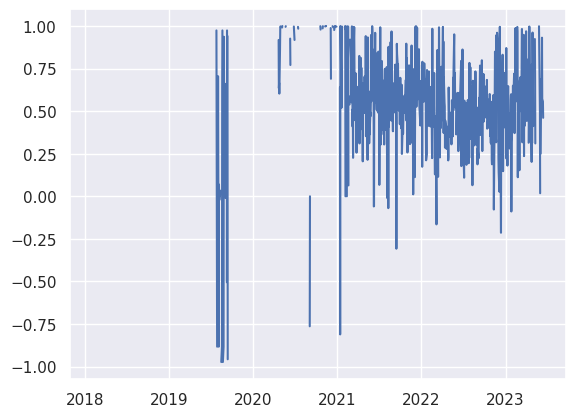

In [ ]:
# visualizing Sentiment
plt.plot(df['Sentiment'])
df['Sentiment'].describe()

In [ ]:
# creating a dataframe with just these 2 parameters

sentiment_close = sentiment.merge(df['Close'].shift(1,freq='B').dropna(), left_index=True, right_index=True).dropna()
sentiment_close.rename(columns={'normalized': 'sentiment'}, inplace=True)

The Null test for correlation between these 2 columns is REJECTED .


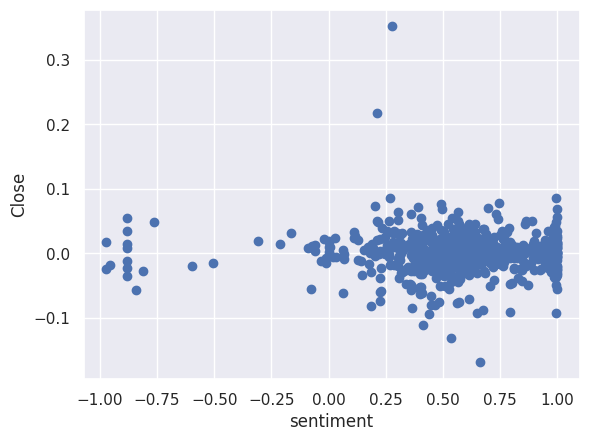

In [ ]:
# checking correlation with df['Close']
plt.scatter(sentiment_close['sentiment'], sentiment_close['Close'])
plt.xlabel('sentiment')
plt.ylabel('Close')

from scipy import stats
res, p = stats.pearsonr(sentiment_close['sentiment'], sentiment_close['Close'])
print ('The Null test for correlation between these 2 columns is',
       'REJECTED' if p>0.05 else 'not rejected. They are correlated',
       'strongly.' if res>0.9 else '.')

* Note that sentiment analysis records start from 2018 so it would be wiser to only test those records against the 'Close' target.

(array([ 16.,   3.,   3.,   8.,  34.,  46., 143., 265., 195., 207.]),
 array([-0.973 , -0.7757, -0.5784, -0.3811, -0.1838,  0.0135,  0.2108,
         0.4081,  0.6054,  0.8027,  1.    ]),
 <BarContainer object of 10 artists>)

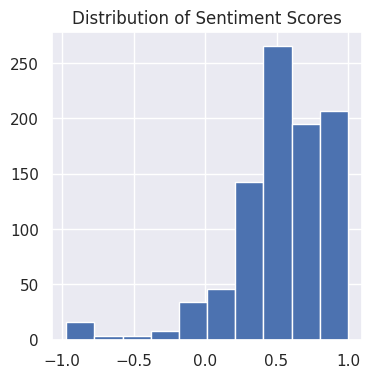

In [ ]:
plt.figure(figsize=(4,4))
plt.title ('Distribution of Sentiment Scores')
plt.hist(sentiment)

Strategy: for the years after Sentiment data was collected, it will be front-filled i.e. we assume the sentiment did not change during those 'gap' periods.

For the years before Sentiment data was collected, it will be filled with the mode of the distribution.

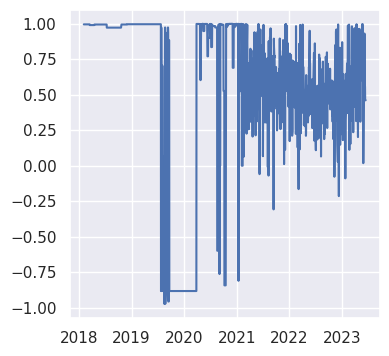

In [ ]:
df['Sentiment']['2018':] = df['Sentiment']['2018':].fillna(method='bfill') # fill with the last sentiment i.e. assume sentiment did not change
plt.figure(figsize=(4,4))
plt.plot (df['Sentiment'])

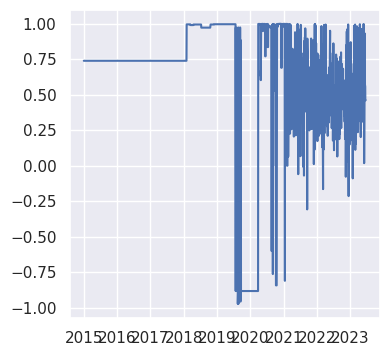

In [ ]:
df['Sentiment'] = df['Sentiment'].fillna(df['Sentiment'].median())
plt.figure(figsize=(4,4))
plt.plot (df['Sentiment'])

Text(0, 0.5, 'Close')

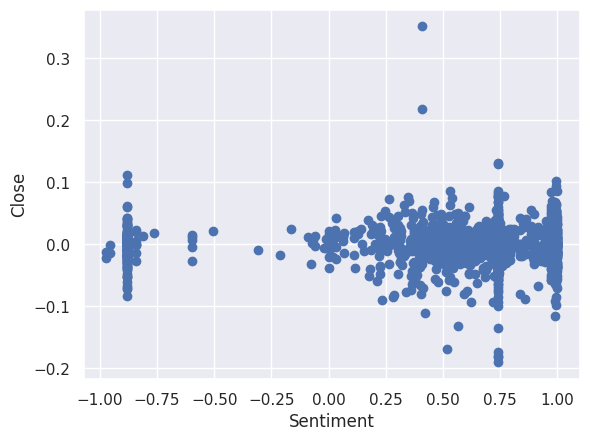

In [ ]:
plt.scatter(df['Sentiment'], df['Close'])
plt.xlabel('Sentiment')
plt.ylabel('Close')

In [ ]:
# checking again for missing values
display(df.isna().sum())
df.info()

Volume                   0
Close                    1
SPX                      1
EPS                      0
Days From Quarter End    0
Sentiment                0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2129 entries, 2023-06-16 to 2015-01-02
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Volume                 2129 non-null   int64  
 1   Close                  2128 non-null   float64
 2   SPX                    2128 non-null   float64
 3   EPS                    2129 non-null   float64
 4   Days From Quarter End  2129 non-null   int64  
 5   Sentiment              2129 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 181.0 KB


* the missing values are from 'Close' (SPX and NFLX), the result of differencing the column, and  will be dropped

In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2128 entries, 2023-06-15 to 2015-01-02
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Volume                 2128 non-null   int64  
 1   Close                  2128 non-null   float64
 2   SPX                    2128 non-null   float64
 3   EPS                    2128 non-null   float64
 4   Days From Quarter End  2128 non-null   int64  
 5   Sentiment              2128 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 116.4 KB


In [ ]:
# df.to_csv('/content/drive/MyDrive/stock_model/completed_dataframe.csv')
df.to_csv('/content/drive/MyDrive/stock_model/completed_dataframe2.csv')


# Feature Engineering - Normalization

Most of the models and functionalities are designed to take advantage of the properties of Gaussian/normal distributions, so it's important though not always essential to esnure that features are as close to this distribution as possible. All the features will be tested for normality using the **Shapiro Test**. For features that do not pass normality tests, transformations will be applied if possible. This was just brute-force coding, trying different transformations until I got one that passed or in the case of Volume, came close (p = 0.0059). After each test, the `.info()` of the column Series will be run to confirm that there are no unexpected Null values as a result of the transformations.

**Note**: None of the features are statistically significant but EPS comes close. We wil repeat this test after discretizing the *Close* parameter.

In [ ]:
# putting the df in chronological order
df = df[::-1]
df.tail()

,Volume,Close,SPX,EPS,Days From Quarter End,Sentiment
Date,,,,,,
2023-06-09,12372830,-0.009404,-0.009321,4.0,-21,0.5721
2023-06-12,5967712,-0.027738,-0.006933,4.0,-18,0.5570
2023-06-13,7820535,-0.011773,-0.000819,4.0,-17,0.4610
2023-06-14,8413089,-0.010003,-0.012178,4.0,-16,0.4610
2023-06-15,7099915,0.029892,0.003672,4.0,-15,0.4610


In [ ]:
volume = np.sqrt(np.sqrt(np.log(np.log(np.log(df['Volume'])))))

k2, p = stats.shapiro(volume)
print(f"p is {p}. \nThe null hypothesis can be",
      "rejected. The distribution is not likely normal." \
      if p<0.05 else "accepted. The distribution is likely normal.")
volume.isna().sum()

p is 0.0058625019155442715. 
The null hypothesis can be rejected. The distribution is not likely normal.


0

**Note**: The p factor is almost 0.05 and I will accept this because the depth of transformation already done on this feature.

In [ ]:
spx = df['SPX'].diff()

k2, p = stats.shapiro(spx)
print(f"p is {p}. \nThe null hypothesis can be",
      "rejected. The distribution is not likely normal." \
      if p<0.05 else "accepted. The distribution is likely normal.")
spx.isna().sum()

p is 1.0. 
The null hypothesis can be accepted. The distribution is likely normal.


1

In [ ]:
eps = df['EPS'].diff()

k2, p = stats.shapiro(eps)
print(f"p is {p}. \nThe null hypothesis can be",
      "rejected. The distribution is not likely normal." \
      if p<0.05 else "accepted. The distribution is likely normal.")
eps.isna().sum()

p is 1.0. 
The null hypothesis can be accepted. The distribution is likely normal.


1

In [ ]:
days = df['Days From Quarter End']

k2, p = stats.shapiro(days)
print(f"p is {p}. \nThe null hypothesis can be",
      "rejected. The distribution is not likely normal." \
      if p<0.05 else "accepted. The distribution is likely normal.")
days.isna().sum()

p is 1.9089818594842413e-24. 
The null hypothesis can be rejected. The distribution is not likely normal.


0

* After several failed attempts, not able to get this into a normalized distribution. It will be selected for MinMax Scaling.

In [ ]:
sent = df['Sentiment']

k2, p = stats.shapiro(sent.values)
print(f"p is {p}. \nThe null hypothesis can be",
      "rejected. The distribution is not likely normal." \
      if p<0.05 else "accepted. The distribution is likely normal.")
sent.describe()

p is 0.0. 
The null hypothesis can be rejected. The distribution is not likely normal.


count    2128.000000
mean        0.624209
std         0.474562
min        -0.973000
25%         0.589175
50%         0.739500
75%         0.973000
max         1.000000
Name: Sentiment, dtype: float64

* Like with `days` this will be selected for MinMaxScaling.

p is 1.0. 
The null hypothesis can be accepted. The distribution is likely normal.


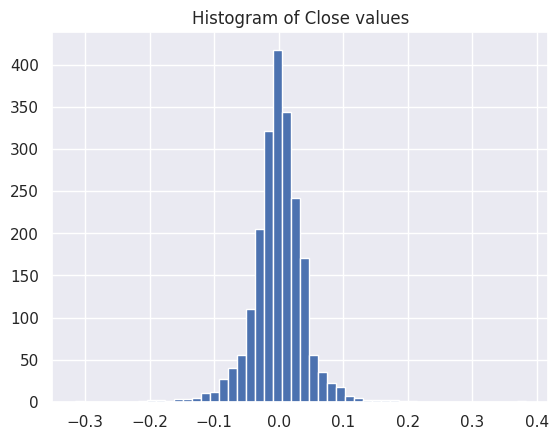

In [ ]:
close = df['Close'].diff()
plt.hist(close, bins=50)
plt.title ('Histogram of Close values')

k2, p = stats.shapiro(close)
print(f"p is {p}. \nThe null hypothesis can be",
      "rejected. The distribution is not likely normal." \
      if p<0.05 else "accepted. The distribution is likely normal.")

**Conclusions**:
1. EPS, SPX, Volume, Close (target): normalized features and can be standardized with a StandardScaler.
2. Days and Sentiment will be fitted with a MinMaxScaler.


# Feature Engineering (Output)

There are 3 important modifications required for the target/output of the timeseries forecast model:

1. Discretizing / categorizing the price movement.
2. Time shifting the target variable.
3. Windowing the timeseries.

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/stock_model/completed_dataframe.csv')

## 1. Discretization of Price Movement

The exact stock price value on its own doesn't give us any information to make a financial decision. Also a mse of 0.02 is irrelevant if we're constantly predicting that same error. For this algorithm to be useful, it should be able to predict how the price is *moving*, which will then enable us to determine a strategy (buy low, sell high).


The **Close** value will be converted into a Price movement value with 3 labels:

1 : (Strong Bear 🐻 )

0 : Hold ⏱️ - price variation too low to be worth speculating

1 : (Bull 🐂)

Using qcut will balance the data and give us equal values
Which will be advisable when classifying the data.
I will leave room for brute force hypertuning this parameter if need be, to improve scores.

Text(0.5, 1.0, 'Discretization of `Close` with Pandas Qcut')

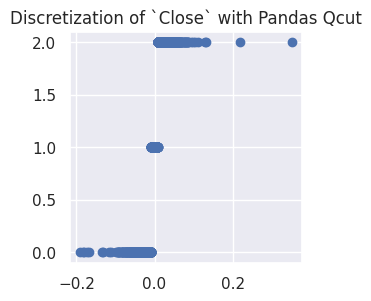

In [ ]:
df['Move'] = pd.qcut(df['Close'], q=3, labels = list(range(3)), retbins=True)[0]
df.head(5)
plt.figure(figsize=(3,3))
plt.scatter(df['Close'], df['Move'])
plt.title('Discretization of `Close` with Pandas Qcut')

### Hypertuning the Discretization

The bins need to be values that won't overbalance the classes but will still reasonable correlation with the features that we have enough to be useful in the model.

1    1638
2     246
0     244
Name: Close, dtype: int64

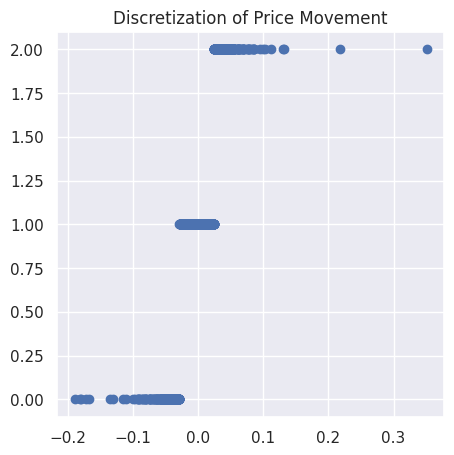

In [ ]:
from scipy.stats import f_oneway, kruskal
## Hypertuning the Discretization
def hypertune_bins(bins):
    """
    function to hypertune the discretization bins.
    receives bins, a list of 2 numbers that will act as the "cut-offs"
    and return the value counts and the one-Way F test results
    """
    def finstat_cut(value, bins):

        if value < bins[0]:
            bin = 0
        elif value > bins[1]:
            bin = 2
        else:
            bin = 1
        return bin

    move = df['Close'].apply(lambda x: finstat_cut(x, bins))
    # plt.figure(figsize=(2,2))
    plt.figure(figsize=(5,5))
    plt.title('Discretization of Price Movement')
    plt.scatter(df['Close'], move)
    display(move.value_counts())

    return move


bins = [-0.029,  0.024]
df['Move'] = hypertune_bins(bins)


## 2. Time Shifting the target variable
As this is a forecasting model, the actual prediction should be time-shifted by one day.

In [ ]:
df['Next'] = df['Move'].shift(-1)
df.tail(3)

,Volume,Close,SPX,EPS,Days From Quarter End,Sentiment,Move,Next
Date,,,,,,,,
2023-06-13,7820535,-0.011773,-0.000819,4.0,-17,0.461,1,1.0
2023-06-14,8413089,-0.010003,-0.012178,4.0,-16,0.461,1,2.0
2023-06-15,7099915,0.029892,0.003672,4.0,-15,0.461,2,NaN


## 3. Windowing the Time Series

To turn time series into supervised learning problem, use Pandas functionality for the Sliding Windows approach, making X (input columns) equal to the previous days's values and y, the target/output column is the predicted price. This will be done for both the **NFLX** `Close` prices and the **SPX** index.

In [ ]:
def make_windows(tmp, window_size=3, horizon=1):
    """
    Input: 1-D time series Dataframe
    output: X 2D time series of window_size
    y: 1D time series lagged by horizon
    """
    data = tmp.copy()

    windows = list(data.rolling(window=window_size))[window_size:]
    window_data = pd.concat([pd.DataFrame(window.T.values) for window in windows])

    window_data.index = data.index[window_size:]

    return window_data

In [ ]:
nflx_windows = make_windows(close.to_frame())
spx_windows = make_windows(spx.to_frame())

### Deeper Sentiment Analysis

I want to test for sentiment analysis with time lag. 3-7 days. (Beyond that I feel is unrealistic for the volatility of the market). This will be approached like hypertuning.

Frame is now 2125 long from previous 2128.


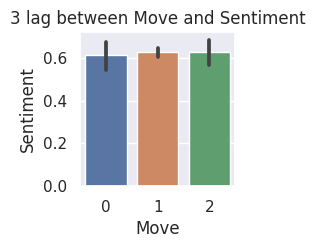

0.912631521383175

After a shift of 3 days, Sentiment and 'Move' are possibly not correlated.
Frame is now 2124 long from previous 2128.


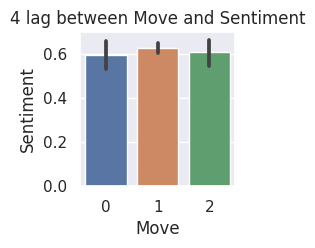

0.912631521383175

After a shift of 4 days, Sentiment and 'Move' are possibly not correlated.
Frame is now 2123 long from previous 2128.


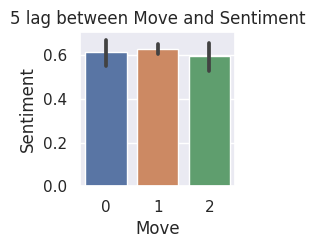

0.912631521383175

After a shift of 5 days, Sentiment and 'Move' are possibly not correlated.
Frame is now 2122 long from previous 2128.


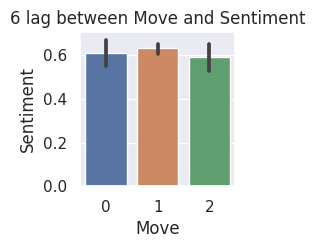

0.912631521383175

After a shift of 6 days, Sentiment and 'Move' are possibly not correlated.


In [ ]:
sentiment_movement = df[['Sentiment', 'Move']].copy()
def tuning_the_sentiment_feature(shift, sentiment_movement=sentiment_movement):

    y = sentiment_movement['Sentiment'].shift(-shift) # time shifting the target value by one day
    tmp = sentiment_movement.drop(columns=['Sentiment']).merge(y, left_index=True, right_index=True, how='outer').dropna()
    print(f"Frame is now {len(tmp)} long from previous {len(sentiment_movement)}.")


    plt.figure(figsize=(2,2))
    sns.barplot(data=tmp, x='Move', y='Sentiment')
    plt.title(f"{shift} lag between Move and Sentiment")
    plt.show()
    catgroup = df.groupby('Move')['Sentiment'].apply(list)
    p = f_oneway(*catgroup)[1]
    display(p)
    print (f"After a shift of {shift} days, {'Sentiment'} and 'Move' are possibly",
            "correlated." if p<0.05 else "not correlated.")

for day in range(3,7):
    tuning_the_sentiment_feature(day)


**Conclusion**: I think we can definitely conclude that this sentiment dataset at least, has no correlation with the price movement.

## Statistical Analysis
* Now that the model, features, target has been prepared to be handled as a classification problem, we will run some tests:
Multinomial Logistic Regression
oneway ANOVA test (and KRUSKAL test for Sentiment and Days).

* First we have to substitute our normalized features into the dataset.

In [ ]:
# first we recreate our dataset
data = pd.DataFrame([volume,sent,days,eps,spx,close]).T # merge the normalized features
data['Move'] = df['Move']
data['Next'] = df['Next']
data = data.merge(nflx_windows, right_index=True, left_index=True) # merge the windows
data = data.merge(spx_windows, right_index=True, left_index=True, suffixes=('', '_SPX')) # spx window
data.drop(columns=['SPX', 'Close'], inplace=True) # they have been made redundant by the windowed parameters
data.rename(columns={'Days From Quarter End': 'Days',
                     'Next': 'Forecast'}, inplace=True)
data.head(2)
data.tail(3)

,Volume,Sentiment,Days,EPS,Move,Forecast,0,1,2,0_SPX,1_SPX,2_SPX
Date,,,,,,,,,,,,
2023-06-13,1.004195,0.461,-17.0,0.0,1,1.0,0.016611,-0.018333,0.015964,-0.008173,0.002388,0.006113
2023-06-14,1.004604,0.461,-16.0,0.0,1,2.0,-0.018333,0.015964,0.001770,0.002388,0.006113,-0.011359
2023-06-15,1.003648,0.461,-15.0,0.0,2,NaN,0.015964,0.001770,0.039895,0.006113,-0.011359,0.015850


Volume


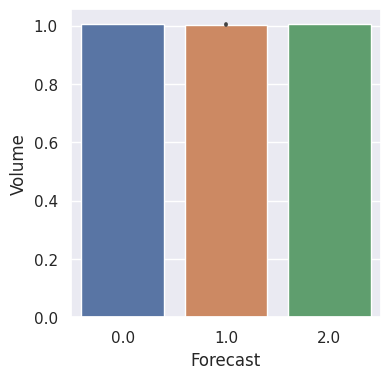

1.37394933281839e-13

Volume and 'Forecast' are possibly correlated.
EPS


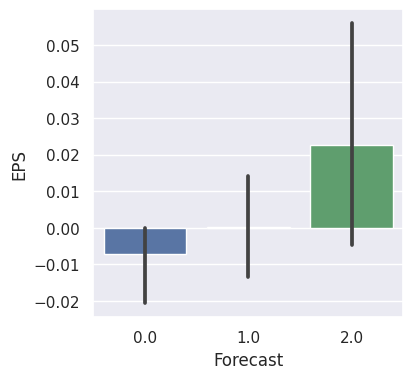

0.35905358790438274

EPS and 'Forecast' are possibly not correlated.
0


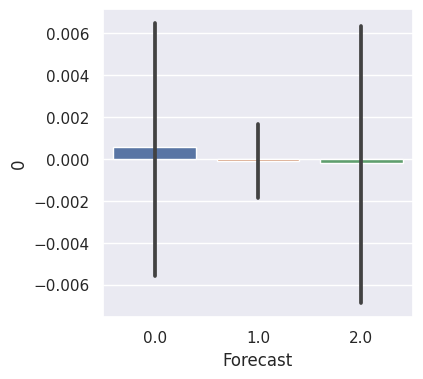

0.9685239605761975

0 and 'Forecast' are possibly not correlated.
1


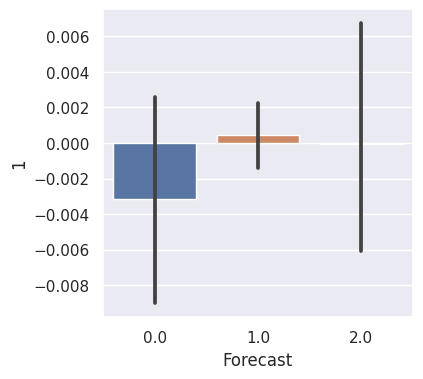

0.4333072009088125

1 and 'Forecast' are possibly not correlated.
2


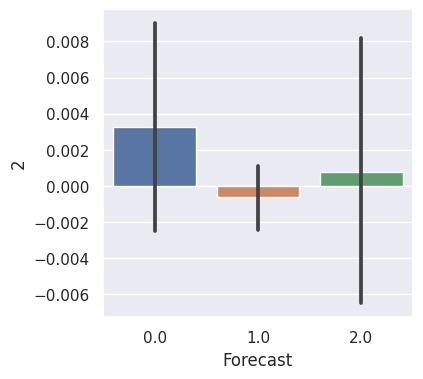

0.3628318647529069

2 and 'Forecast' are possibly not correlated.
0_SPX


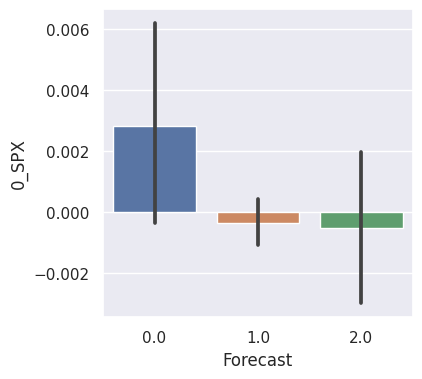

0.03023331163731816

0_SPX and 'Forecast' are possibly correlated.
1_SPX


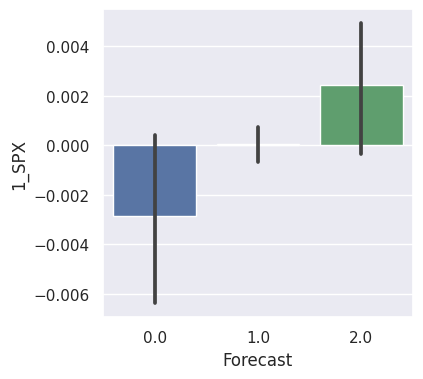

0.004437683583737225

1_SPX and 'Forecast' are possibly correlated.
2_SPX


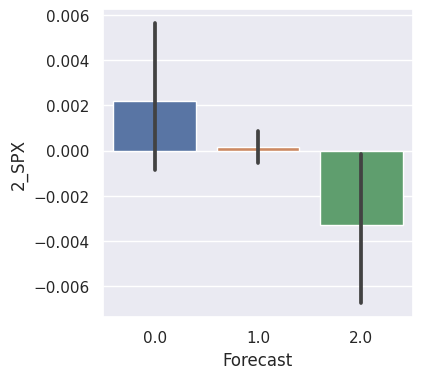

0.00217623841574991

2_SPX and 'Forecast' are possibly correlated.


In [ ]:
# performing the one way ANOVA test
from scipy.stats import f_oneway, kruskal
for col in data.columns:
    if col in ['Forecast', 'Sentiment', 'Days', 'Move']: # sentiment and days will be tested with  kruskal
        continue
    print(col)
    plt.figure(figsize=(4,4))
    sns.barplot(data=data, x='Forecast', y=col)
    plt.show()
    catgroup = data.groupby('Forecast')[col].apply(list)
    p = f_oneway(*catgroup)[1]
    display(p)
    print (f"{col} and 'Forecast' are possibly",
            "correlated." if p<0.05 else "not correlated.")

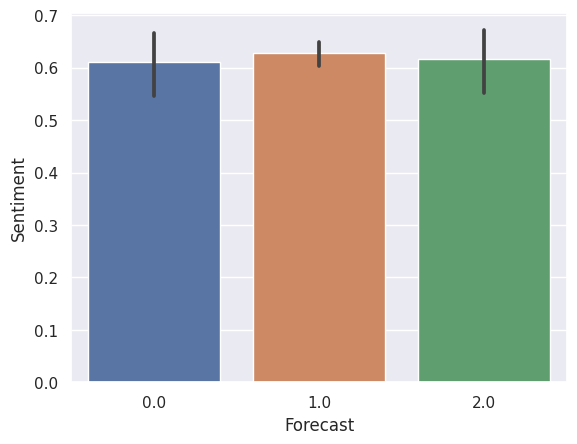

0.46642144549394693

Sentiment and 'Forecast' are possibly not correlated.


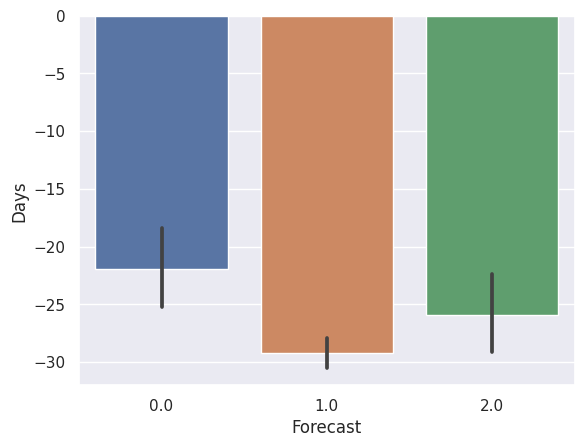

0.00017623731815918865

Days and 'Forecast' are possibly correlated.


In [ ]:
for col in ['Sentiment', 'Days']:
    sns.barplot(data=data, x='Forecast', y=col)
    plt.show()
    catgroup = data.groupby('Forecast')[col].apply(list)
    p = kruskal(*catgroup)[1]
    display(p)
    print (f"{col} and 'Forecast' are possibly",
            "correlated." if p<0.05 else "not correlated.")

In [ ]:
# finally we drop the last unnecessary columns:
drop_columns=['Days', 'Sentiment', 'EPS']
data = data.drop(columns=drop_columns)

Thus ends the relatively vigorous feature engineering. The next notebook will build our model in stages, then tune those hyperparamneters. See you then!

In [ ]:
data.to_csv('/content/drive/MyDrive/stock_model/dataframe_for_model.csv')